## 1. 라이브러리 호출



In [57]:
import re
import os, sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Fixing seeds
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## 2. 데이터셋 불러오기

In [58]:
# 데이터 파일 경로 설정
train_path = '/content/train.csv'
test_path = '/content/test.csv'

# 데이터 파일 읽어오기
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# 데이터 확인
#display(train.head(5))

In [59]:
train.shape, test.shape

((20000, 23), (10000, 22))

In [60]:
#train.info()

In [61]:
#train.describe(include='all')

In [62]:
#train.describe()

## 3. 전처리

In [63]:
train.columns

Index(['ID', 'Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status', 'Income'],
      dtype='object')

In [64]:
# Remove special characters and replace spaces with underscores in column names
train.columns = train.columns.str.replace('(', '', regex=False) \
                               .str.replace(')', '', regex=False) \
                               .str.replace(' ', '_', regex=False)
test.columns = test.columns.str.replace('(', '', regex=False) \
                              .str.replace(')', '', regex=False) \
                              .str.replace(' ', '_', regex=False)

In [65]:
# Select object columns
object_cols = list(train.select_dtypes(include=['object']).columns)

# Correctly formatted regex pattern to match the special characters you listed
pattern = r'[#@&\[\]<()]'

# Remove special characters in object columns
for col in object_cols:
    train[col] = train[col].str.replace(pattern, '', regex=True)
    test[col] = test[col].str.replace(pattern, '', regex=True)

## 4. train_x, train_y, test_x 분리

In [66]:
train_x = train.drop(columns=['ID', 'Income'])
train_y = train['Income']

test_x = test.drop(columns=['ID'])

## 5. Label Encoding

In [67]:
train_x = pd.DataFrame(train_x, columns=train_x.columns)
test_x = pd.DataFrame(test_x, columns=test_x.columns)

# Select object columns
encoding_target = list(train_x.dtypes[train_x.dtypes == "object"].index)

# Apply one-hot encoding
train_x = pd.get_dummies(train_x, columns=encoding_target)
test_x = pd.get_dummies(test_x, columns=encoding_target)

# Align train and test data to ensure they have the same columns
train_x, test_x = train_x.align(test_x, join='left', axis=1)

# Fill NaN values (if any) with 0
test_x.fillna(0, inplace=True)

## 6. Scaling Valiables

In [68]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)


## 7. Split train_x, val_x, train_y, val_y

In [69]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

## 8. 사이킷런 앙상블 학습 + LGBM + XGBoost

In [70]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

models = {
          LGBMRegressor(): 'LGBMRegressor',
          HistGradientBoostingRegressor(): 'HistGradientBoostingRegressor',
          RandomForestRegressor(): 'RandomForestRegressor',
          XGBRegressor(): 'XGBRegressor'
          }

for model in models.keys():
    model.fit(train_x, train_y)
    pred = model.predict(val_x)
    mse = mean_squared_error(val_y, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(val_y, pred)
    print(f'{models[model]}: RMSE {rmse}, R^2 {r2}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 215
[LightGBM] [Info] Start training from score 556.153500
LGBMRegressor: RMSE 594.2618043266764, R^2 0.2826944354484293
HistGradientBoostingRegressor: RMSE 592.4533786031328, R^2 0.28705352448869415
RandomForestRegressor: RMSE 627.3235772640793, R^2 0.20065955843954508
XGBRegressor: RMSE 620.6915860225803, R^2 0.21747128708153107


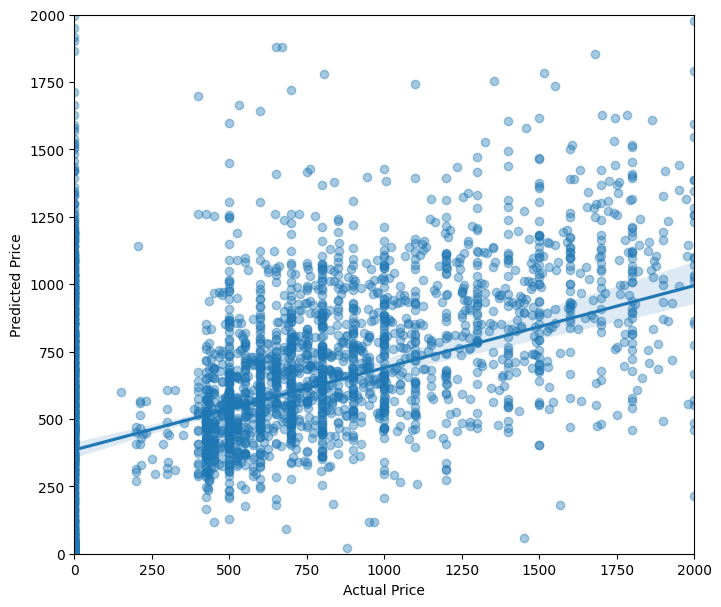

In [71]:
pred_y = model.predict(val_x)
plt.figure(figsize=(8, 7))
sns.regplot(x = val_y, y = pred_y, scatter_kws={'alpha':0.4})
plt.xlim((0, 2000))
plt.ylim((0, 2000))
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

## 9. Pytorch 기반 딥러닝 모델

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [73]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # 입력층
        self.layer1 = nn.Sequential(
            nn.Linear(275, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # 은닉층
        self.layer2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.layer4 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.layer5 = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # 출력층
        self.output = nn.Linear(128, 1)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.output(x)
        return x

model = Model()


## 10. 모델 훈련

In [74]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

#optimizer = optim.Adadelta(model.parameters(), rho=0.9, eps=1e-06)

#optimizer = optim.RMSprop(model.parameters(), lr=0.001)

#optimizer = optim.Adagrad(model.parameters(), lr=0.001)

In [75]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

train_x_tensor = torch.tensor(train_x, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y.values, dtype=torch.int64)

train_ds = TensorDataset(train_x_tensor, train_y_tensor)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

torch.manual_seed(42)
num_epochs = 10
loss_history = []

for epoch in range(num_epochs):
    epoch_loss = 0
    accuracy_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        y_batch = y_batch.float()
        loss = loss_fn(pred, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        is_correct = (torch.argmax(pred, dim=1) == y_batch.long()).float()
        accuracy_hist_train += is_correct.sum()
    epoch_loss /= len(train_dl.dataset)  # 평균 loss 계산
    loss_history.append(epoch_loss)  # 평균 loss 기록
    accuracy_hist_train /= len(train_dl.dataset)
    print(f'에포크 {epoch}  정확도 {accuracy_hist_train:.4f}  손실 {epoch_loss:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


에포크 0  정확도 0.4329  손실 8229.4295
에포크 1  정확도 0.4329  손실 7851.5425
에포크 2  정확도 0.4329  손실 7935.3999
에포크 3  정확도 0.4329  손실 7844.4229
에포크 4  정확도 0.4329  손실 7852.3706
에포크 5  정확도 0.4329  손실 7852.5199
에포크 6  정확도 0.4329  손실 7866.1822
에포크 7  정확도 0.4329  손실 7859.9353
에포크 8  정확도 0.4329  손실 7862.0765
에포크 9  정확도 0.4329  손실 7838.4942


## 11. 평가

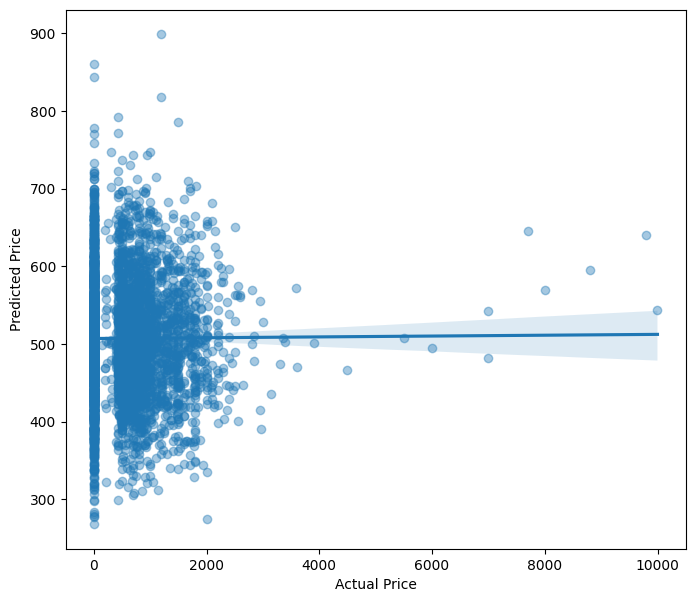

In [76]:
val_x_tensor = torch.tensor(val_x, dtype=torch.float32)

pred = model(val_x_tensor)
pred_y = pred.detach().numpy()

plt.figure(figsize=(8, 7))
sns.regplot(x=val_y, y=pred_y, scatter_kws={'alpha':0.4})
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

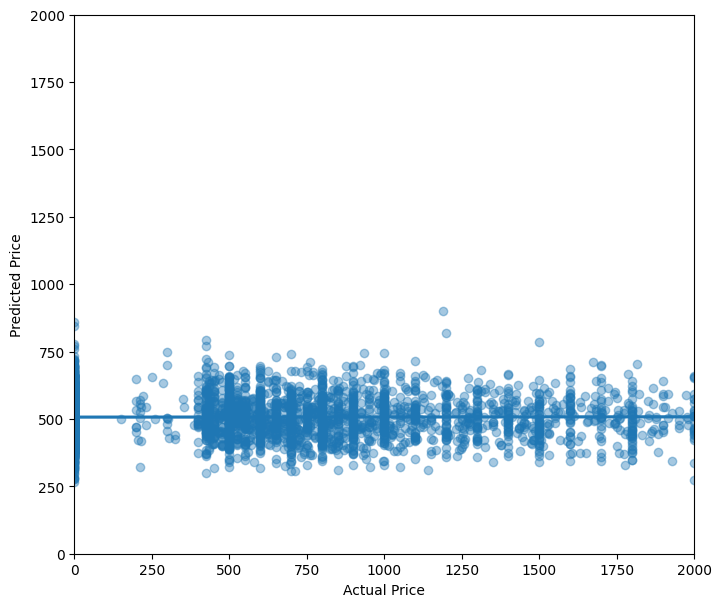

In [77]:
plt.figure(figsize=(8, 7))

sns.regplot(x=val_y, y=pred_y, scatter_kws={'alpha': 0.4})

plt.xlim((0, 2000))
plt.ylim((0, 2000))
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

## 12. 예측

In [81]:
test_x_tensor = torch.tensor(test_x, dtype=torch.float32)
preds = model(test_x_tensor)

## 13. 예측 데이터셋 저장

In [82]:
submission = pd.read_csv('/content/sample_submission.csv')
submission['Income'] = preds.detach().numpy()
submission

,ID,Income
0,TEST_0000,663.393677
1,TEST_0001,523.680847
2,TEST_0002,559.327209
3,TEST_0003,412.162384
4,TEST_0004,440.521149
...,...,...
9995,TEST_9995,563.518433
9996,TEST_9996,439.027679
9997,TEST_9997,560.584412
9998,TEST_9998,521.681213


In [83]:
submission.to_csv('/content/sample_submission.csv', index=False)